In [1]:
!pip install transformers
!pip install Keras-Preprocessing
!pip install kerastuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 606.2 kB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement kerastuner (from versions: none)
ERROR: No matching distribution found for kerastuner


In [2]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
import pandas as pd
import numpy as np
import os
import torch
import random
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
#from xgboost import XGBRegressor
import lightgbm as lgb
from tqdm import tqdm
tqdm.pandas()

# neural network library
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import preprocessing
from keras_preprocessing.text import Tokenizer
import kerastuner as kt

<ipython-input-3-ad5823baf599>:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/BhavanishDhamnaskar/poem_d/main/Poem_classification%20-%20train_data.csv')
train.head()

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [5]:
train = train.dropna()

In [6]:
test = pd.read_csv('https://github.com/BhavanishDhamnaskar/poem_d/blob/main/Poem_classification%20-%20test_data.csv', error_bad_lines=False, warn_bad_lines=True)

test.head()

<ipython-input-6-5310415f6808>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test = pd.read_csv('https://github.com/BhavanishDhamnaskar/poem_d/blob/main/Poem_classification%20-%20test_data.csv', error_bad_lines=False, warn_bad_lines=True)
<ipython-input-6-5310415f6808>:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test = pd.read_csv('https://github.com/BhavanishDhamnaskar/poem_d/blob/main/Poem_classification%20-%20test_data.csv', error_bad_lines=False, warn_bad_lines=True)
Skipping line 34: expected 1 fields, saw 7
Skipping line 112: expected 1 fields, saw 3
Skipping line 145: expected 1 fields, saw 2
Skipping line 224: expected 1 fields, saw 3
Skipping line 233: expected 1 fields, saw 6
Skipping line 265: expected 1 fields, saw 4
Skipping line 278: expected 1 fields, saw 4
Skipping line 291: e

,<!DOCTYPE html>
0,"<html lang=""en"" data-color-mode=""auto"" data-li..."
1,<head>
2,"<meta charset=""utf-8"">"
3,"<link rel=""dns-prefetch"" href=""https://githu..."
4,"<link rel=""dns-prefetch"" href=""https://avata..."


In [7]:
print('train.shape',train.shape, 'test.shape',test.shape)

train.shape (837, 2) test.shape (1011, 1)


In [8]:
df = pd.concat([train, test])

In [9]:
df.head()

,Genre,Poem,<!DOCTYPE html>
1,Music,In the thick brushthey spend the...,NaN
2,Music,Storms are generous. ...,NaN
3,Music,—After Ana Mendieta Did you carry around the ...,NaN
4,Music,for Aja Sherrard at 20The portent may itself ...,NaN
5,Music,"for Bob Marley, Bavaria, November 1980 Here i...",NaN


In [10]:
df['Genre'].value_counts()

Music          238
Death          231
Environment    227
Affection      141
Name: Genre, dtype: int64

In [11]:
mapping = {'Environment':0,'Music':1,'Death':2,'Affection':3}
df['ylabel'] = df['Genre'].map(mapping)

In [12]:
df.head()

,Genre,Poem,<!DOCTYPE html>,ylabel
1,Music,In the thick brushthey spend the...,NaN,1.0
2,Music,Storms are generous. ...,NaN,1.0
3,Music,—After Ana Mendieta Did you carry around the ...,NaN,1.0
4,Music,for Aja Sherrard at 20The portent may itself ...,NaN,1.0
5,Music,"for Bob Marley, Bavaria, November 1980 Here i...",NaN,1.0


In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
from nltk.tokenize import word_tokenize

import re

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(str(text).lower())

    # Define stop words
    stop_words = ['number', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
            'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she','her', 'hers', 'herself', 'its', 'itself', 'they', 'them', 'their',
            'theirs', 'themselves', 'this', 'am', 'is', 'are', 'was', 'were', 'be',
            'been', 'being', 'have', 'has', 'it', 'had', 'having', 'do', 'does', 'did',
            'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'as', 'until', 'of',
            'at', 'by', 'for', 'with', 'to', 'on', 'is', 'in', 'al', 'at', 'then']

    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Define regular expressions for preprocessing
    # Here, we'll remove punctuation and special characters
    regex = r"[^\w\s]"

    # Apply regular expressions
    filtered_text = ' '.join(filtered_tokens)
    filtered_text = re.sub(regex, '', filtered_text)
    return filtered_text

In [15]:
df['Poem_Processed'] = df['Poem'].apply(preprocess_text)

In [16]:
df['Poem_len'] = df['Poem'].apply(lambda x: len(str(x)))

In [17]:
df['Poem_Processed_len'] = df['Poem_Processed'].apply(lambda x: len(str(x)))

In [18]:
df.head()

,Genre,Poem,<!DOCTYPE html>,ylabel,Poem_Processed,Poem_len,Poem_Processed_len
1,Music,In the thick brushthey spend the...,NaN,1.0,thick brushthey spend hottest part day soakin...,205,112
2,Music,Storms are generous. ...,NaN,1.0,storms generous something so easy surrender ...,191,92
3,Music,—After Ana Mendieta Did you carry around the ...,NaN,1.0,after ana mendieta carry around matin star ho...,242,185
4,Music,for Aja Sherrard at 20The portent may itself ...,NaN,1.0,aja sherrard 20the portent may memory wallace...,209,151
5,Music,"for Bob Marley, Bavaria, November 1980 Here i...",NaN,1.0,bob marley bavaria november 1980 here brilli...,197,144


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vectorizer = TfidfVectorizer()

In [21]:
X = vectorizer.fit_transform(df['Poem_Processed'])

In [22]:
train_data = X[0:837]

In [23]:
train_label = df['ylabel'][0:837]

In [24]:
test_data = X[837:]

In [25]:
test_label = df['ylabel'][837:]

In [26]:
print('train', train_data.shape, train_label.shape)
print('test', test_data.shape, test_label.shape)

train (837, 8869) (837,)
test (1011, 8869) (1011,)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=42)

# Multinominal Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

mnb = MultinomialNB(force_alpha=True)

In [29]:
# common function for all classifier model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def report_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.47      0.36      0.41        75
         1.0       0.40      0.50      0.44        82
         2.0       0.33      0.50      0.40        78
         3.0       0.00      0.00      0.00        42

    accuracy                           0.39       277
   macro avg       0.30      0.34      0.31       277
weighted avg       0.34      0.39      0.35       277



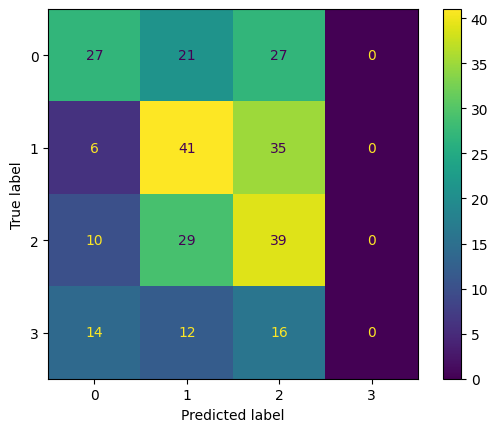

In [30]:
mnb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 3.0, 5.0,7.0, 10],
}

mnb_grid_model = GridSearchCV(estimator=mnb, param_grid=mnb_param_grid, cv=10)

report_model(mnb_grid_model)

In [31]:
mnb_grid_model.best_params_


{'alpha': 2.0}

# XGBClassifier for classification

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

In [33]:
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # 'subsample': np.arange(0.5, 1.0, 0.1),
    # 'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'booster': ['gbtree'],
    # 'objective': ['binary:logistic'],
}

random_model = RandomizedSearchCV(estimator=xgb, param_distributions= param_dist, cv=10,n_iter=50, n_jobs= -1)

              precision    recall  f1-score   support

         0.0       0.40      0.39      0.39        75
         1.0       0.36      0.39      0.37        82
         2.0       0.38      0.38      0.38        78
         3.0       0.27      0.24      0.25        42

    accuracy                           0.36       277
   macro avg       0.35      0.35      0.35       277
weighted avg       0.36      0.36      0.36       277



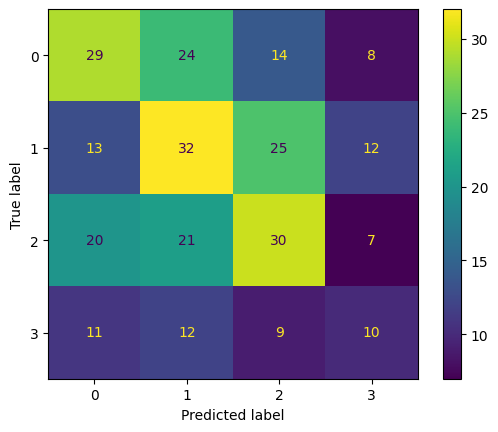

In [34]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Assuming X_train, y_train, X_test, y_test are defined elsewhere in your code

def report_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

xgb = XGBClassifier()

param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'booster': ['gbtree'],
    # 'objective': ['binary:logistic'], # Uncomment if needed
}

random_model = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=10, n_iter=50, n_jobs=-1, random_state=42)

report_model(random_model)


# Random Forest Classifier

In [37]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

              precision    recall  f1-score   support

         0.0       0.45      0.45      0.45        75
         1.0       0.35      0.55      0.43        82
         2.0       0.48      0.32      0.38        78
         3.0       0.30      0.14      0.19        42

    accuracy                           0.40       277
   macro avg       0.39      0.37      0.36       277
weighted avg       0.41      0.40      0.39       277



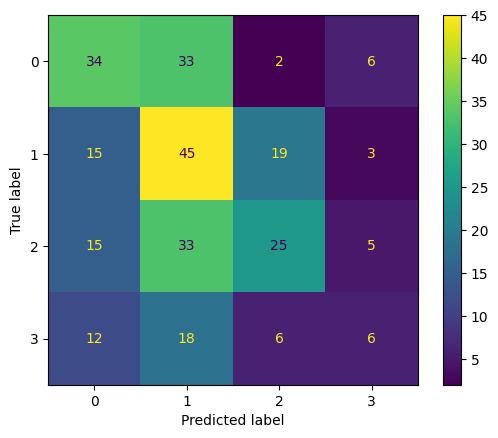

In [38]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
report_model(clf)

              precision    recall  f1-score   support

         0.0       0.44      0.56      0.49        75
         1.0       0.39      0.40      0.40        82
         2.0       0.40      0.40      0.40        78
         3.0       0.35      0.17      0.23        42

    accuracy                           0.41       277
   macro avg       0.40      0.38      0.38       277
weighted avg       0.40      0.41      0.40       277



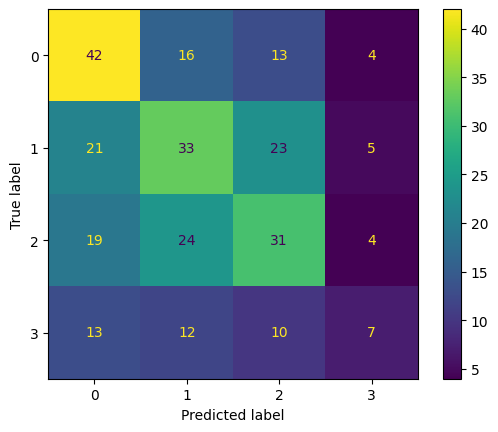

In [39]:
rfc = RandomForestClassifier()
# Define a grid of hyperparameters to search through
param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

grid_model_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv=5)

report_model(grid_model_rfc)

# bert_classy

In [40]:
!pip install transformers

In [43]:
import pandas as pd

# Correct URLs for the raw CSV files
train_url = 'https://raw.githubusercontent.com/BhavanishDhamnaskar/poem_d/main/Poem_classification%20-%20train_data.csv'
test_url = 'https://raw.githubusercontent.com/BhavanishDhamnaskar/poem_d/main/Poem_classification%20-%20test_data.csv'  # Update this URL

# Reading the data
train = pd.read_csv(train_url)
test = pd.read_csv(test_url, error_bad_lines=False, warn_bad_lines=True)

# Display the data
display(train)
display(test)

# Concatenate the data
data = pd.concat([train, test], axis=0)
display(data.info())

# Drop missing values
data = data.dropna()


<ipython-input-43-4aa778479d86>:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test = pd.read_csv(test_url, error_bad_lines=False, warn_bad_lines=True)
<ipython-input-43-4aa778479d86>:9: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test = pd.read_csv(test_url, error_bad_lines=False, warn_bad_lines=True)


,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...
...,...,...
836,Environment,Why make so much of fragmentary blue In here a...
837,Environment,"Woman, I wish I didn't know your name. What co..."
838,Environment,"Yonder to the kiosk, beside the creek, Paddle ..."
839,Environment,You come to fetch me from my work to-night Whe...


,Genre,Poem
0,Music,A woman walks by the bench I’m sitting onwith ...
1,Music,"Because I am a boy, the untouchability of beau..."
2,Music,"Because today we did not leave this world,We n..."
3,Music,"Big Bend has been here, been here. Shouldn’t i..."
4,Music,"I put shells there, along the lip of the road...."
...,...,...
145,Environment,"To pick a tulip from the garden, the red one. ..."
146,Environment,We are as clouds that veil the midnight moon; ...
147,Environment,"When pulled, the spider web took another form...."
148,Environment,Whose woods these are I think I know. His hous...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   991 non-null    object
 1   Poem    987 non-null    object
dtypes: object(2)
memory usage: 23.2+ KB


None

In [44]:
print(data['Genre'].value_counts())
Name0=data['Genre'].unique().tolist()
Name=sorted(Name0)
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))
data['Genre']=data['Genre'].map(normal_mapping)

Environment    252
Music          250
Death          244
Affection      241
Name: Genre, dtype: int64


In [45]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #self.model_name = '../input/bert-base-uncased'  # Inet-not-connect
        self.model_name = 'bert-base-uncased'          # Inet-connect
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [46]:
BSV = BertSequenceVectorizer()
data['Poem_bert']=data['Poem'].progress_apply(lambda x: BSV.vectorize(x))
display(data[0:2])

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 987/987 [00:21<00:00, 46.06it/s]


,Genre,Poem,Poem_bert
1,3,In the thick brushthey spend the...,"[-0.19468293, 0.4254165, -0.26951814, -0.47039..."
2,3,Storms are generous. ...,"[-0.012234281, -0.3351899, -0.22740427, 0.0576..."


In [47]:
review=[]
for item in data['Poem_bert']:
    review+=[item]

dataX0=pd.DataFrame(review)
dataY=data['Genre']
print(dataX0.shape)
print(dataY.shape)

(987, 768)
(987,)


In [48]:
n=len(data)
N=list(range(n))
random.shuffle(N)

In [49]:
trainX0 = dataX0.iloc[0:len(train)].reset_index(drop=True)
trainY = dataY.iloc[0:len(train)].reset_index(drop=True)
testX0 = dataX0.iloc[len(train):].reset_index(drop=True)
testY = dataY.iloc[len(train):].reset_index(drop=True)
print(trainX0.shape)
print(testX0.shape)

(841, 768)
(146, 768)


In [50]:
trainX = trainX0.iloc[:,0:200]
testX = testX0.iloc[:,0:200]
X = np.array(trainX)
y = np.array(trainY)

In [51]:
clf = lgb.LGBMRegressor(max_depth=3,n_estimators=1000,learning_rate=0.01)
ss = ShuffleSplit(n_splits=5,train_size=0.8,test_size=0.2,random_state=0)

In [52]:
for train_index, test_index in ss.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    clf.fit(X_train, Y_train)
    print(clf.score(X_test, Y_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44869
[LightGBM] [Info] Number of data points in the train set: 672, number of used features: 200
[LightGBM] [Info] Start training from score 1.680060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [53]:
y_pred = clf.predict(testX)

In [54]:
PRED=[]
for pred in y_pred:
    PRED+=[int(round(pred,0))]
ANS=list(testY)
print(PRED[0:5])
print(ANS[0:5])

[1, 1, 2, 2, 2]
[3, 3, 3, 3, 3]


In [55]:
from sklearn.metrics import classification_report
print(classification_report(ANS,PRED,target_names=Name,digits=4))

              precision    recall  f1-score   support

   Affection     0.8333    0.0500    0.0943       100
       Death     0.0290    0.1538    0.0488        13
 Environment     0.1818    0.4800    0.2637        25
       Music     0.0000    0.0000    0.0000         8

    accuracy                         0.1301       146
   macro avg     0.2610    0.1710    0.1017       146
weighted avg     0.6045    0.1301    0.1141       146

